# Barcode Decoding Model
This is a neural network which is aimed at identifying specific barcodes. Data is the intensity of reflected light obtained from a colour sensor.

This program also attempts to make use of data augmentation functions, as the amount of data available is very limited and as seen below, even with the attempts of data augmentation results in poor accuracy. 

References:
- https://www.youtube.com/watch?v=JRlyw6LO5qo
- https://www.youtube.com/watch?v=ixathu7U-LQ
- https://www.youtube.com/watch?v=9j-_dOze4IM

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as io
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.data_augment import DataAugment as augment
from utils.sampler import Sampler as sampler

In [2]:
# gathering data
dataDir = "data/"

data = [io.loadmat(dataDir + file)['array'] for file in os.listdir(dataDir)]
data = torch.tensor(data).type(torch.LongTensor).reshape((-1, 200))

# getting labels from file names
def label(letter):
    if letter == 'A':
        return 0
    elif letter == 'B':
        return 1
    elif letter == 'C':
        return 2
    elif letter == 'D':
        return 3
    
labels = [file[0] for file in os.listdir(dataDir)]
labels = map(label, labels)
labels = torch.tensor(list(labels))

In [3]:
# splitting data and labels into training and testing sets
testing_data_x, testing_data_y, training_data_x, training_data_y = sampler.split(data, labels, 4)

In [4]:
# data augmentation of training data
# shifting pass
for i in range(len(training_data_x)):
    aug_tensor, aug_label = training_data_x[i], training_data_y[i]
    
    aug_tensor = augment.shift(aug_tensor, shift=10)
    
    training_data_x = torch.cat((training_data_x, aug_tensor.reshape(-1, len(aug_tensor))))
    training_data_y = torch.cat((training_data_y, aug_label.reshape(1)))

# multiplying pass
for i in range(len(training_data_x)):
    aug_tensor, aug_label = training_data_x[i], training_data_y[i]
    
    aug_tensor = augment.multiply(aug_tensor, factor=4)
    
    training_data_x = torch.cat((training_data_x, aug_tensor.reshape(-1, len(aug_tensor))))
    training_data_y = torch.cat((training_data_y, aug_label.reshape(1)))

# shifting pass
for i in range(len(training_data_x)):
    aug_tensor, aug_label = training_data_x[i], training_data_y[i]
    
    aug_tensor = augment.shift(aug_tensor, shift=25)
    
    training_data_x = torch.cat((training_data_x, aug_tensor.reshape(-1, len(aug_tensor))))
    training_data_y = torch.cat((training_data_y, aug_label.reshape(1)))

In [5]:
# data augmentation of testing data
# shifting pass
for i in range(len(testing_data_x)):
    aug_tensor, aug_label = testing_data_x[i], testing_data_y[i]
    
    aug_tensor = augment.shift(aug_tensor, shift=15)
    
    testing_data_x = torch.cat((testing_data_x, aug_tensor.reshape(-1, len(aug_tensor))))
    testing_data_y = torch.cat((testing_data_y, aug_label.reshape(1)))

# multiplication pass
for i in range(len(testing_data_x)):
    aug_tensor, aug_label = testing_data_x[i], testing_data_y[i]
    
    aug_tensor = augment.multiply(aug_tensor, factor=3)
    
    testing_data_x = torch.cat((testing_data_x, aug_tensor.reshape(-1, len(aug_tensor))))
    testing_data_y = torch.cat((testing_data_y, aug_label.reshape(1)))

In [6]:
# defining model
class decode(nn.Module):
    def __init__(self):
        super(decode, self).__init__()
        
        self.fc1 = nn.Linear(200, 140)
        self.fc2 = nn.Linear(140, 140)
        self.fc3 = nn.Linear(140, 140)
        self.fc4 = nn.Linear(140, 4)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1)
    
model = decode()

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 384.91it/s]


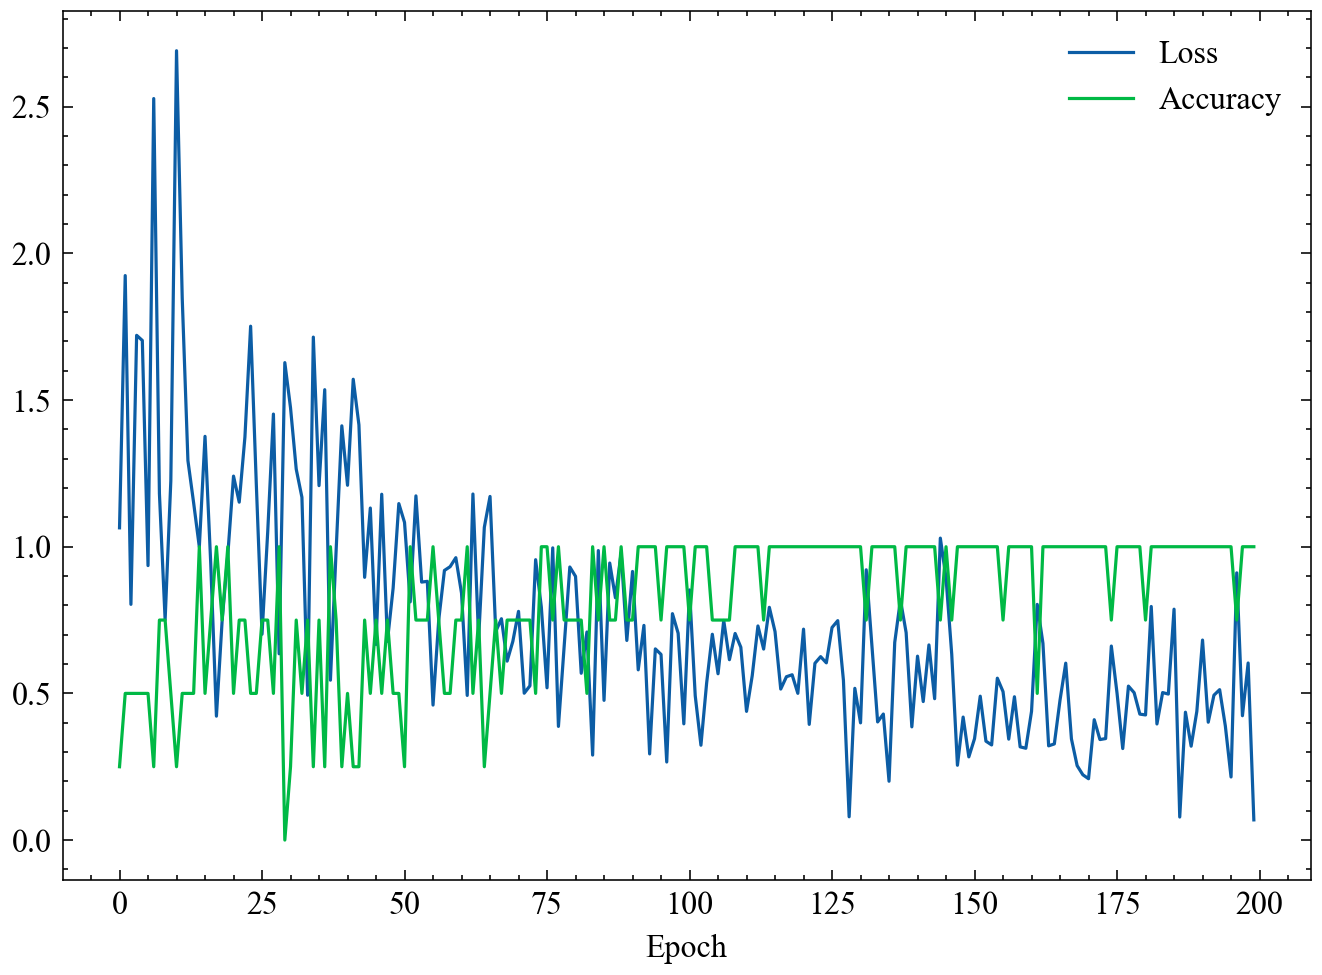

In [7]:
# training
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

batch_size = 4
epochs = 200

losses, accuracies = [], []

for i in (t := trange(epochs)):
    samp = np.random.randint(0, training_data_x.shape[0], size=(batch_size))
    
    X = training_data_x[samp].reshape((-1, 200)).detach().clone().float()
    Y = training_data_y[samp].detach().clone().long()
    
    model.zero_grad()
    
    output = model(X)
    results = torch.argmax(output, dim=1)
    
    accuracy = (results == Y).float().mean()
    
    loss = F.nll_loss(output, Y)
    loss.backward()
    
    optimizer.step()
    
    losses.append(loss.item())
    accuracies.append(accuracy.item())

plt.figure(dpi=230, figsize=(7,5))
plt.style.use(['science', 'no-latex'])

plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [8]:
# testing
result_y = torch.argmax(model(testing_data_x.reshape((-1, 200)).detach().clone().float()), dim=1)
print('Test accuracy: {0}%'.format((result_y == testing_data_y).float().mean().item()*100))
print('Model answers: ', result_y)
print('True answers: ', testing_data_y)

Test accuracy: 50.0%
Model answers:  tensor([2, 0, 0, 3, 2, 0, 0, 3, 2, 0, 0, 3, 2, 0, 0, 3])
True answers:  tensor([1, 0, 1, 3, 1, 0, 1, 3, 1, 0, 1, 3, 1, 0, 1, 3])
